# Exploring Methods for Improved Reasoning in Large Language Models: Examples from the ARC-Dataset - **DEMO VERSION**

In [48]:
# Necessary imports
import asyncio
import pandas as pd
import random
from PIL import Image as PILImage
from IPython.display import display
from utils import *

from prompt_generators import (
    generate_coding_prompt_with_reasoning_info,
    create_basic_prompt,
    generate_coding_prompt,
    generate_prompt_with_image,
    generate_code_fixing_prompt,
    create_reasoning_model_prompt,
)
from llm_utils import generate_llm_response, initialize_client, query_reasoning_model, generate_llm_response_async
from eval import (
    extract_solution,
    evaluate_solution,
    convert_output_to_array,
    extract_code,
    execute_transform_function,
)
from helper_functions import (
    get_grid_sizes,
    format_grid_sizes_to_string,
    check_task_symmetries,
    format_task_symmetries_to_string,
    get_change_grid_text,
)
from transformation_rules import get_transformation_rule

In [50]:
# Initial Setup
# I picked these, because I found them interesting - most of them CAN be solved, but might not be solved every attempt
good_example_tasks = ["0d3d703e", "1cf80156", "2204b7a8", "22168020", "22eb0ac0", "23581191", "25d8a9c8", "25ff71a9",
             "27a28665", "28bf18c6", "2dee498d", "31aa019c", "3618c87e", "3bd67248", "4258a5f9", "f25ffba3",
             "50cb2852", "72ca375d", "834ec97d", "a2fd1cf0", "a5313dff", "d0f5fe59", "1e0a9b12", "b6afb2da"]           

check_dataset()                                 # ensure task data is complete, otherwise downloads the correct data
train, eval = load_files_from_json()
test_set = filter_tasks_by_grid_size(train)     # filters the tasks down to only tasks with max grid size 15x15 as explained in the paper
print(f"Test set has {len(test_set)} tasks in it.")

reuse_generated_transformation_rule = True      # in order to save a lot of time, I suggest re-using the already generated transformation rules || set to false if reasoning model should generate new ones
solution_found = False                          # needed to know if additional steps are necessary

ARC data complete.
Test set has 300 tasks in it.


In [61]:
task = random.choice(good_example_tasks)        # or select your own! any of the test_set.keys() are valid!
task = "834ec97d"
print(f"Task to process: {task}")

Task to process: 834ec97d


### Display the Task Image

To get an idea of the kind of task we are dealing with, let's look at the image generated by another script first. These images were generated using the "generate_images_matplotlib"-notebook.


Task examples for 834ec97d look like this:


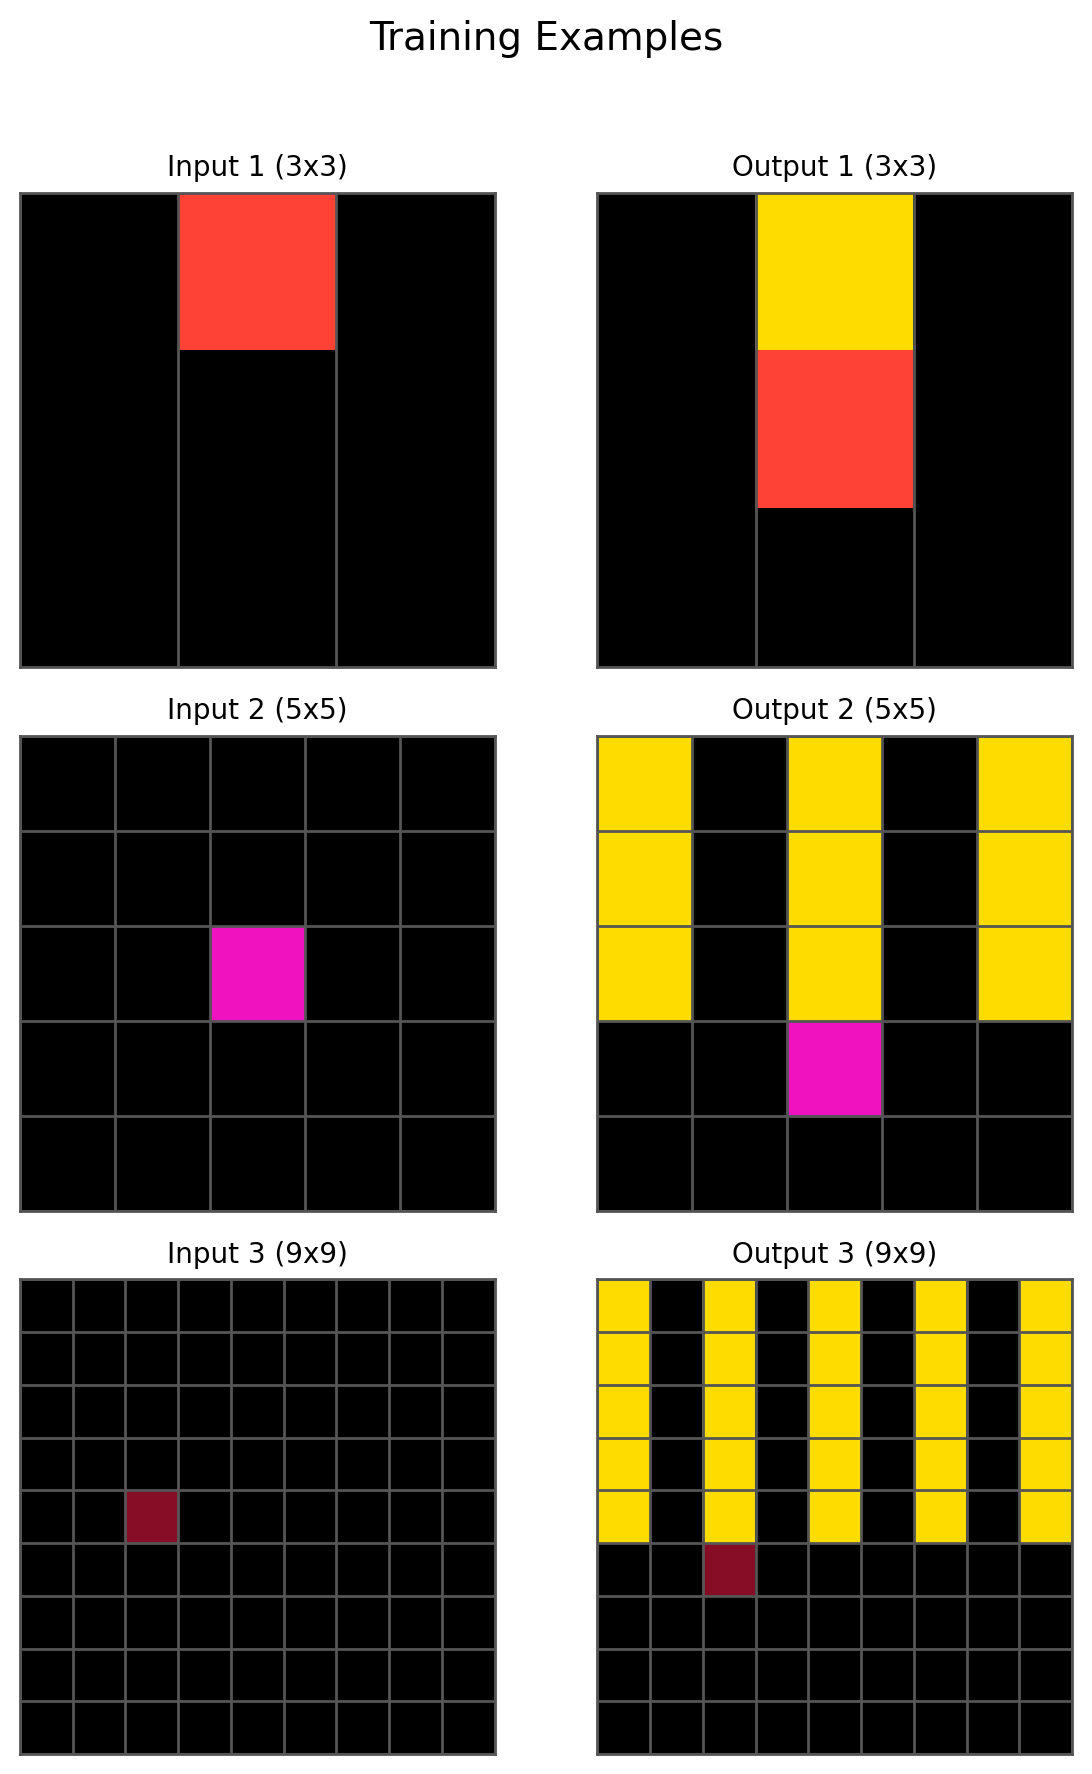

########################################
And the test set for 834ec97d is looks like this.
The output of that is hidden and not shown to the LLMs.


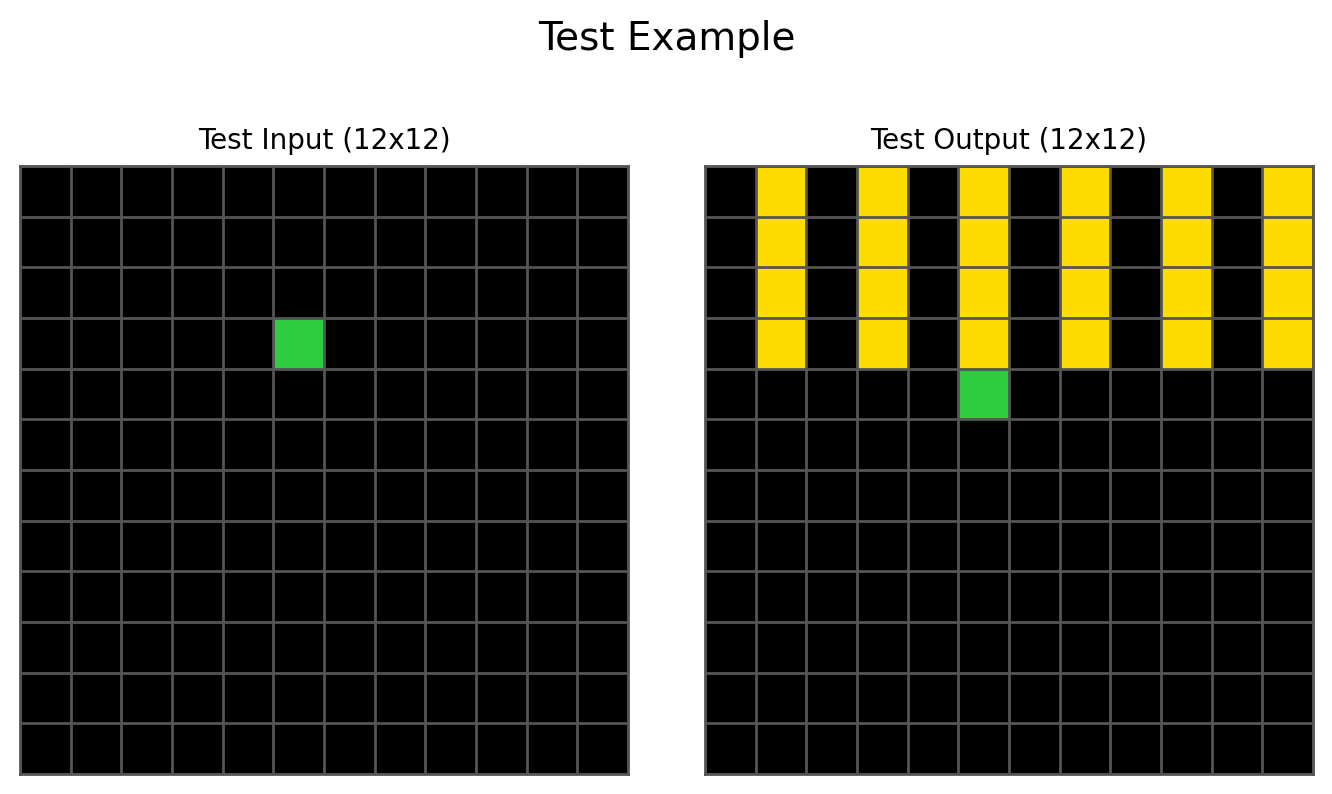

In [62]:
# Replace 'path/to/your/image.png' with the actual path to your image file
train_path = f"generated_images1/{task}_training_examples.png"
test_path = f"generated_images1/{task}_test_case.png"
# Load the image using Pillow
try:
    img = PILImage.open(train_path)
    print(f"Task examples for {task} look like this:")
    display(img)
    print("#" * 40)
    img = PILImage.open(test_path)
    print(
        f"And the test set for {task} is looks like this.\nThe output of that is hidden and not shown to the LLMs."
    )
    display(img)
except Exception as e:
    print(f"An error occurred: {e}")

### Helper Functions

Helper functions were designed to give the LLMs additional information that may be useful and that was difficult for the LLM to determine itself.

- **Grid Sizes** are essential for predicting the test output grid size. It is the first thing I ask the LLM to determine. But counting list of integers can be difficult and can be prone to errors. Therefore, I added this extra function, which determines the grid sizes and formats that into a string for the prompt.

- **Symmetries**: some of the ARC tasks become much easier when knowing that symmetries are involved. However, I never saw LLMs focus on that in initial testing. TThis is why I created these helper functions. However, I am worried that providing information about symmetries in tasks where they are not relevant and just coincidental, might be problematic.

- **Change Grids**: The main prompt for the reasoning model relies on analyzing what changes between input and output grid for each example. This can be much easier with these grids. This idea was taken from [another solution attempt in the ARC challenge](https://jeremyberman.substack.com/p/how-i-got-a-record-536-on-arc-agi)


In [63]:
# Execute helper functions and display their results
grid_sizes, test_input_size = get_grid_sizes(test_set[task])
grid_sizes_formatted = format_grid_sizes_to_string(grid_sizes, test_input_size)

symmetries, test_input_symmetries = check_task_symmetries(test_set[task])
symmetries_formatted = format_task_symmetries_to_string(
    symmetries, test_input_symmetries
)

change_grid_formatted = get_change_grid_text(test_set[task])

print("########## This is the additional information given to the LLM ##########")
print(grid_sizes_formatted + "\n")
print(symmetries_formatted + "\n")
print(change_grid_formatted)

########## This is the additional information given to the LLM ##########
Grid sizes:

Training Example 1 Input: 3x3
Training Example 2 Input: 5x5
Training Example 3 Input: 9x9
Training Example 1 Output: 3x3
Training Example 2 Output: 5x5
Training Example 3 Output: 9x9
Test Input Grid Size: 12x12

Symmetry Information:
Example 1:
  Input Grid: Vertical Symmetry
  Output Grid: Vertical Symmetry

Example 2:
  Input Grid: Vertical Symmetry
  Output Grid: Vertical Symmetry

Example 3:
  Input Grid: Vertical Symmetry
  Output Grid: No symmetries found.

Test Input Grid: No symmetries found.

Additionally, you are given the following grids that show the changes between input and output. If an example pair stays the same in a certain cell, that will be marked with ' -- '. A change from input to output will be shown by 'value_input' -> 'value_output'.

Example 1 Changes (3x3):
4->0|0->4|4->0
4->0|0->2|4->0
4->0|4->0|4->0

Example 2 Changes (5x5):
 -- | -- | -- | -- | -- 
 -- | -- | -- | -- | -

### Prompt Generation
The next step is to construct a prompt from this information. This is done here:

In [64]:
# Create and display reasoning model prompt
messages = create_reasoning_model_prompt(task=test_set[task],
                                         grid_size_str=grid_sizes_formatted,
                                         symmetry_str=symmetries_formatted,
                                         change_grid_str=change_grid_formatted
                                         )
print("This is what the prompt for the reasoning model looks like:")
print("-" * 60)
print(messages[0]['content'])

This is what the prompt for the reasoning model looks like:
------------------------------------------------------------
You will be given multiple example input-output pairs and an additional test input. The outputs were produced by applying a transformation rule to each of the inputs.
Your task is to understand this transformation rule (which is consistent between examples) and apply the same logic to the test case to solve it. The inputs and outputs are each 'grids'. A grid is a rectangular matrix
of integers between 0 and 9 (inclusive). The integer values represent colors.

In your step-by-step approach:
1. Please ensure you determine the correct output grid size.
2. Focus on what stays the same and what changes between input and output grid.
3. From your observations, determine a transformation rule.
4. Evaluate your reasoning, by checking if the transformation rule works for all examples.

Here are the examples of input and output grids and the test case that you have to solve:



### Getting Transformation rule from Reasoning Model
To produce the transformation rule, simply send the messages to the reasoning model via an API.
However, the reasoning model generally produces **A LOT of tokens** - this will take a lot of time.
I therefore *suggest to use the transformation rule that I generated in a previous run*.
They are stored in results/final_approach/transformation_rules_full.json and will be used by default - if you want to avoid this and produce your own reasoning rule, simply overwrite (here or in the second cell of this notebook).

However, the reasoning model uses a rather high **temperature of 0.6**. This, in combination with other parameters, is meant to prevent the model from falling into infinite repetitions, which tends to happen with smaller reasoning models. This high temperature can lead to diverse outputs (also the model performs very good overall). I just wanted to mention this, as this can lead to different transformation rules across different runs (and I therefore suggest to use the already generated transformation rule).

This highlights one of the **limitations of my approach**: the reasoning model only gets to generate one single hypothesis. If this hypothesis is wrong, the coding model will try to implement a wrong hypothesis...

In [65]:
# Display transformation rule
# This will use the previously determined and saved hypothesis unless reuse_generated_transformation_rule is set to False
if reuse_generated_transformation_rule:
    transformation_rule, reasoning = get_transformation_rule(task)       # simulates request: much faster than it actually is
else:                                                                    # but: ensures that we have the same reasoning model answer for the rest of this process
    transformation_rule, reasoning = query_reasoning_model(messages)     # this is the actual query to Qwen-QwQ-32B
    print(f"Qwen-QwQ Reasoning: {reasoning}")
    print(f"Qwen-QwQ Transformation Rule: {transformation_rule}")

Reasoning for task 834ec97d:

Reasoning:
Okay, let's try to figure out the transformation rule here. Hmm, so looking at the examples, the inputs and outputs are grids of varying sizes. The key is to see how the input grid changes to become the output.

Starting with Example 1: The input is a 3x3 grid with a 2 in the center of the top row. The output has a 4 in that position and a 2 below it. Wait, so the original non-zero number (the 2) seems to be moving down? Let me check the positions. The input's [0][1] is 2, and in the output, that becomes 4, and the [1][1] is now 2. So maybe the original number is being duplicated downwards? But why the 4? Wait, maybe the number is being multiplied by 2? Because 2 becomes 4, and then the next row has a 2. Wait, but where does the 2 come from? Or perhaps it's moving down and the original cell is set to double?

Alternatively, maybe the non-zero number is being placed in a symmetrical position. Let me think again. The input has vertical symmetry, a

### Program Synthesis
Now that the model has generated a hypothesis of the transformation rule, the program synthesis part starts. The hypothesis is given to the coding model, along with all necessary information to produce code. The coding model tries to implement that hypothesis in code.

**Fallbacks:** there are situations where the coding model is instructed to create its *own* solution. This can happen in two situations:
- Sometimes, the reasoning model cannot come to a conclusion within its token limit (64,000), this the transformation_rule will be None.
- Additionally, the hypothesis can simply *be wrong*. Ideally, the reasoning model would create **multiple hypotheses**, but I did not do that in this attempt, as it would have cost a lot of time. To still have a shot at getting a correct solution for this, the coding model will be instructed to attempt its own reasoning and solution IF implementing the reasoning model's solution fails.

In [66]:
# 
if transformation_rule is not None and transformation_rule != "":
    coding_prompt_transformation_rule = generate_coding_prompt_with_reasoning_info(test_set[task], transformation_rule)
    print('Coding Model + Transformation Rule from Reasoning Model - Prompt:\n\n')
    print(coding_prompt_transformation_rule[0]['content'])
    print(coding_prompt_transformation_rule[1]['content'])
else:
    print("Transformation rule not found, resorting to standalone coding model approach.")

coding_prompt = generate_coding_prompt(test_set[task])
print("\n\nCoding Model Standalone Prompt:\n\n")
print(coding_prompt[0]['content'])
print(coding_prompt[1]['content'])


Coding Model + Transformation Rule from Reasoning Model - Prompt:


You are a highly skilled python programmer. You will be given multiple paired example input and outputs. The outputs were produced by applying a transformation rule to the inputs. Your task is to implement that transformation rule in code. The inputs and outputs are each 'grids'. A grid is a rectangular matrix of integers between 0 and 9 (inclusive). The integer values represent colors. 
The transformation rule that you have to deduce might have multiple components and can be fairly complex. Luckily, a smart assistant has already thought about what the transformation rule might be. You need to consider this assistant's reasoning and then generate the transformation rule in code. If you find little mistakes in the description of the transformation rule, you may fix them.
Here are the examples of input and output grids represented as list[list[int]]:

Training Examples
Example 1: Input
[
[4, 0, 4],
[4, 0, 4],
[4, 4, 4]]


In [69]:
### Start Generating Programs ###

# General Settings for the approach:
config = {
    'coding_model':'qwen/qwen-2.5-coder-32b-instruct',
    'solution_type': 'program_synthesis',
    'temperatures': [0.1, 0.3, 0.5, 0.7, 0.9],
    'samples_per_step': 10,
    'code_correction_steps': 4
}

# Async client is necessary as Alibaba Cloud AND Openrouter do not support n-samples parameter.
# Instead of using n-parameter, I simply send n requests at the same time, which has the same effect.
# The only API that reliably supported that was Mistral, which was not used in the final approach
client = initialize_client('openrouter_async')
print("Client initialized!")

code_results = []
sample_counter = 1
temperatures = config['temperatures']
n = config['samples_per_step']

# determine which prompt to use
if transformation_rule is not None and transformation_rule != "":
    messages = coding_prompt_transformation_rule
else: 
    messages = coding_prompt


# start the generation loop
print(f"Attempting to solve task {task} through program synthesis...")
for temp in temperatures:
    print(f"Generating {config['samples_per_step']} solutions using temperature {temp}")
    
    tasks = [generate_llm_response_async(client=client, 
                                         model=config['coding_model'], 
                                         temperature=temp, 
                                         messages=messages) 
                 for _ in range(n)]
    results = await asyncio.gather(*tasks)
    
    # Check if good result was found, so we can stop generating programs
    # Extract code from LLM answers:
    generated_programs = []    
    for result in results:
        extracted_code = extract_code(result)
        generated_programs.append(extracted_code)
    print(f"Saved {len(generated_programs)} from output.")
    
    # Then run the code generated using exec() -- not best practice! 
    # But easier to set up than sandboxing
    for i, generated_code in enumerate(generated_programs):
        print(f"Attempting to run program #{i}...")
        generated_output_grids = []
        dicts_list = []
        
        # Set up individual input/output examples as arrays
        for example in test_set[task]['train']:
            example_input = example['input']
            example_output = np.array(example['output'])
            # Then execute generated code for each example
            output_grid_with_llm_code = execute_transform_function(generated_code, example_input)
            generated_output_grids.append(output_grid_with_llm_code)
            try:
                solution_array = np.array(output_grid_with_llm_code)
            except:
                print("No numpy array could be made :(")
            # Compare generated output to actual output
            result = evaluate_solution(solution_array, example_output)
            dicts_list.append(result)
        for d in dicts_list:
            print(d)

        # Calculate evaluation for each code generation
        percentage_correct_values = [d['percentage_correct'] for d in dicts_list]
        average_percentage_correct = sum(percentage_correct_values) / len(percentage_correct_values)
        count_perfect_scores = sum(1 for d in dicts_list if d['percentage_correct'] == 1.0)
        print("Code sample: " + str(i), 
              "Percentage correct: " + str(round(average_percentage_correct, 2)),
              "Num perfect scores: " + str(round(count_perfect_scores, 2)))
        
        # Add to results list          
        row = (
        {
            'task': task,
            'sample_num': sample_counter,
            'full_answer': results[i],
            'extracted_code': generated_code,
            'generated_grids': generated_output_grids,
            'average_percentage_correct': average_percentage_correct,
            'count_perfect_scores': count_perfect_scores,
            'temperature': temp,
            'generation_step': 0
        })
        code_results.append(row)
        sample_counter += 1
    
    # Save to dataframe and csv  
    df = pd.DataFrame(code_results)
    df.to_csv("results/demo_solutions.csv", index=False)
        
    # Check if solution found:
    if not (df.query("task == @task and average_percentage_correct == 1").empty):
        print("Correct solution found, moving to next task.")
        solution_found = True
        break
    else:
        print("No correct solution found in this batch.")

Client initialized!
Attempting to solve task 834ec97d through program synthesis...
Generating 10 solutions using temperature 0.1
Saved 10 from output.
Attempting to run program #0...
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.0}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.68}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.7}
Code sample: 0 Percentage correct: 0.46 Num perfect scores: 0
Attempting to run program #1...
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.0}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.68}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.7}
Code sample: 1 Percentage correct: 0.46 Num perfect scores: 0
Attempting to run program #2...
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.0}
{'answer_extracted': True, 'correct_grid_size': True, 'perce

### Let's take a look at the code that model produced

In [44]:
# If a solution was found,show the code implementation here:
if solution_found:
    solution_func = (
        df.
        query("task == @task and average_percentage_correct == 1")
        .head(1)
        .iloc[0]['extracted_code']
    )
    
    print("Function that solves all example input-output pairs:\n")
    print(solution_func)
    
    print("Expected Output:\n")
    for line in test_set[task]['test'][0]['output']:
        print(line)
    generated_output = execute_transform_function(solution_func, test_set[task]['test'][0]['input'])    
    print("Generated Output:\n")
    for line in generated_output:
        print(line)

# Else, look at the best solution found so far
# Code fixing OR resorting to baseline from reasoning model might be necessary
else:
    best_solution = (
        df
        .query("task == @task")
        .sort_values("average_percentage_correct", ascending=False)
        .head(1)
        .iloc[0]['extracted_code']
    )
    
    print("Best solution found so far:\n")
    print(best_solution)

    print("Expected output:\n")
    for line in test_set[task]['test'][0]['output']:
        print(line)
    generated_output = execute_transform_function(best_solution, test_set[task]['test'][0]['input'])    
    print("Generated Output:\n")
    for line in generated_output:
        print(line)

Best solution found so far:

def transform_grid(grid):
    rows = len(grid)
    cols = len(grid[0]) if rows > 0 else 0
    result = [[0] * cols for _ in range(rows)]
    
    for r in range(rows):
        for c in range(cols):
            if grid[r][c] != 0:
                # Center Check
                if rows % 2 == 1 and cols % 2 == 1 and r == rows // 2 and c == cols // 2:
                    result[r][c] = grid[r][c]
                else:
                    # Set Original Cell to 4
                    result[r][c] = 4
                    # Move Value Down
                    if r + 1 < rows:
                        result[r + 1][c] = grid[r][c]
                    # Fill Column Above
                    for i in range(r):
                        result[i][c] = 4
                    # Checkerboard Pattern
                    for i in range(r):
                        for j in range(cols):
                            if j != c:
                                result[i][j] = 4 if j 

### Self-Debugging Step
IF no solution that solves ALL examples was found during the initial sampling step, the system should try to self-debug. For this reason, I give it the best 3 solutions it created.

However, during initial testing, I found that some code solutions are too bad to be fixed. Thats why I only consider solutions with a score of 70% or above.

For this demo, I also reduce the code fixing steps to 2.

Also, the Self-Debugging Step did not have a lot of influence on the final results. I believe better results could have been achieved by giving this task back to the reasoning model, which could potentially have spotted mistakes in its previous reasoning easier.



In [45]:
# First determine which solutions to attempt to fix:
# These will be the top 3 solutions that either solve one task or have a higher than 0.7 score
from async_funcs import fix_code_with_llm

if not solution_found:
    attempt_fixing = (
        df
        .query("task == @task and \
                average_percentage_correct != 1 and \
                (average_percentage_correct > 0.7 or \
                count_perfect_scores > 1)")
        .drop_duplicates(subset=["average_percentage_correct"], keep='first')
        .sort_values(["count_perfect_scores", "average_percentage_correct"], ascending=False)
        .groupby("task")
        .head(3)
    )
    if not attempt_fixing.empty: 
        df_code_fix = await fix_code_with_llm(attempt_fixing=attempt_fixing, 
                                             task=test_set[task], 
                                             client=client)
    else: print("No previous program fullfills the requirements for code fixing (>0.7 score or 1 example solved)")
else:
    print("Solution already found, no need for code fixing step!")

Attempting to fix code for 834ec97d.
#Attempting to fix program 1 out of 3 -- Attempt #1 out of 2.
Generating code...
Generating 5 solutions using temperature 0.5
Saved 5 from output.
Attempting to run program #0...
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 1.0}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.68}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.8}
0 0.8266666666666668 1
Attempting to run program #1...
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 1.0}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.64}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.8}
1 0.8133333333333335 1
Attempting to run program #2...
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 1.0}
{'answer_extracted': True, 'correct_grid_size': True, 'percentage_correct': 0.64}
{'answer_extracted': Tr

### Check if any of the attempted fixes worked
However, as mentioned: the self-debugging step **rarely** led to big improvements. I believe that this simply shows that the coding model "doesn't know any better". It may be able to fix simple coding mistakes, but will likely not detect problems in the underlying reasoning.

In [46]:
if not solution_found:
    if not (df_code_fix.query("task == @task and average_percentage_correct == 1").empty):
        print("Correct solution found during self debugging step!")
        solution_found = True
    else: print("No solution found even after attempting to fix the best code samples :(")

No solution found even after attempting to fix the best code samples :(


### Last Resort: Having the Reasoning Model solve the problem directly
While the "preferred" solution for me is the program synthesis solution, the reasoning model itself is also relatively good at this type of task but it is slow and lacks the tools to verify its own actions. However, I use it as a fallback option!

In [35]:
from prompt_generators import create_reasoning_model_prompt_fallback

if not solution_found:
    print("Attempting to solve the problem via directly asking reasoning model!")
    # Generate prompt for direct solution
    messages = create_reasoning_model_prompt_fallback(test_set[task], grid_size_str=grid_sizes_formatted, change_grid_str=change_grid_formatted)
    print("Generated prompt for fallback solution from reasoning model:\n\n" + messages[0]['content'])
    print("Sending request to reasoning model, this may take a while to process...")
    answer, reasoning = query_reasoning_model(messages)
    
    print("Evaluating answer")
    extracted_answer = None     # Initialize to None before the try block
    try:
        extracted_answer_temp = extract_solution(answer)            
        extracted_answer = convert_output_to_array(extracted_answer_temp)
    except ValueError as e:
        print(f"Error converting extracted solution to NumPy array: {e}")
        extracted_answer = None
    
    correct_solution = np.array(test_set[task]['test'][0]['output'])
    result = evaluate_solution(extracted_answer, correct_solution)
    
    if result['percentage_correct'] == 1:
        print("Correct Solution found!")
    else:
        print("Failed to determine correct solution -- Score: " + str(result['percentage_correct']))
else: 
    print("Solution already found in previous steps, no fallback required.")

Attempting to solve the problem via directly asking reasoning model!
Generated prompt for fallback solution from reasoning model:

You are an extremely talented puzzle solver and reasoning assistant. Your task is to understand this transformation rule (which is consistent between examples) and apply the same logic to the test case to solve it.
The inputs and outputs are each 'grids'. A grid is a rectangular matrix of integers between 0 and 9 (inclusive). The integer values represent colors.

In your step-by-step approach:
1. Please ensure you determine the correct output grid size.
2. Focus on what stays the same and what changes between input and output grid.
3. From your observations, determine a transformation rule.
4. Evaluate your reasoning, by checking if the transformation rule works for all examples.

Here are the grids:
    
Training Examples
Example 1: Input
[
[1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
[1, 0, 0, 0, 0, 0, 3, 0, 0, 2],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
[1, 0, 0, 0, 0, 0, 0,

### Expected Output and Produced Output
The reasoning model uses a temperature setting of 0.6 which is relatively high. 
The output quality can differ between requests. Sometimes, it helps to simply re-run the model. This highlights the problem of generating only one answer with an LLM - which the repeated sampling + program synthesis is supposed to fix.

In [36]:
# result in more in depth:
print("Score: " + str(result['percentage_correct']))
print("\nExpected output:\n")
print(correct_solution)

print("\nOutput produced by reasoning model:\n")
print(extracted_answer)

Score: 1.0

Expected output:

[[5 5 0 0 0 0 0 0 0 4]
 [5 0 0 0 0 4 0 0 4 4]
 [5 0 0 0 0 0 0 0 0 4]
 [5 0 0 5 0 0 0 0 0 4]
 [5 0 0 0 0 0 4 0 0 4]
 [5 0 0 5 0 0 0 0 0 4]
 [5 0 0 0 0 0 0 0 0 4]
 [5 0 0 0 5 0 0 0 0 4]
 [5 0 5 0 0 0 4 0 0 4]
 [5 0 0 0 0 0 0 0 0 4]]

Output produced by reasoning model:

[[5 5 0 0 0 0 0 0 0 4]
 [5 0 0 0 0 4 0 0 4 4]
 [5 0 0 0 0 0 0 0 0 4]
 [5 0 0 5 0 0 0 0 0 4]
 [5 0 0 0 0 0 4 0 0 4]
 [5 0 0 5 0 0 0 0 0 4]
 [5 0 0 0 0 0 0 0 0 4]
 [5 0 0 0 5 0 0 0 0 4]
 [5 0 5 0 0 0 4 0 0 4]
 [5 0 0 0 0 0 0 0 0 4]]
